### Problem 9.2 : Applying QSVM with PennyLane

PennyLane is an open-source software framework for quantum machine learning, quantum chemistry, and quantum computing, with the ability to run on all hardware.

Link - https://pennylane.ai/datasets/

#### Why Use PennyLane?
- **Hybrid Quantum-Classical Learning:** PennyLane allows seamless integration between quantum circuits and classical machine learning libraries like TensorFlow or PyTorch, enabling hybrid models that leverage both classical and quantum computing strengths.
- **Flexibility in Device Choice: **With various backend options (simulators and real devices), users can choose based on performance needs or availability.
- **Automatic Differentiation:** PennyLane supports automatic differentiation, making it easier to optimize parameters within quantum circuits using gradient-based methods.


In [1]:
# !pip install pennylane
# !pip install pennylane --upgrade

In [2]:
import pennylane as qml
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
from sklearn.svm import SVC

**qml.device:** 
- **Definition:** This function is used to load a specific quantum device on which quantum circuits will be executed. It creates an instance of the Device class, which interprets and executes quantum operations.
- **Usage:** You specify the type of device (e.g., default.qubit, lightning.qubit) and parameters such as the number of qubits (wires) and whether to use shots for statistical sampling.

In [3]:
# Define a PennyLane device
dev = qml.device("default.qubit", wires=2)

**qml.qnode:**
- **Definition: **A QNode is a decorator that wraps a Python function containing quantum operations. It encapsulates the quantum circuit and associates it with a specific device.
- **Usage: **You define a quantum function that includes quantum gates and measurements, then use the @qml.qnode(dev) decorator to create a QNode.

Pauli Z gate Knowledge Link - https://www.sharetechnote.com/html/QC/QuantumComputing_Gate_X.html

In [4]:
@qml.qnode(dev)
def circuit(x):
    # Feature map (ZZFeatureMap equivalent)
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0)) #Pauli Z Operator

In [5]:
def compute_kernel(X1, X2):
    """Compute the kernel matrix using PennyLane."""
    n_samples_1 = X1.shape[0]
    n_samples_2 = X2.shape[0]
    kernel_matrix = np.zeros((n_samples_1, n_samples_2))
    
    for i in range(n_samples_1):
        for j in range(n_samples_2):
            kernel_matrix[i, j] = circuit(X1[i]) * circuit(X2[j])
    
    return kernel_matrix

In [6]:
def generate_circle_data(n_samples=100, noise=0.1):
    # Generate circle dataset
    phi = 2 * np.pi * np.random.random(n_samples)
    r = np.random.random(n_samples)
    
    X = np.zeros((n_samples, 2))
    X[:, 0] = r * np.cos(phi)
    X[:, 1] = r * np.sin(phi)
    
    y = 2 * (r > 0.5) - 1
    
    if noise > 0:
        X += noise * np.random.randn(*X.shape)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

In [7]:
# Omit this section from your logical understanding, this is just for visualisation

import matplotlib.pyplot as plt

def visualize_data(X, y, title="Circle Dataset"):
    """Visualize the dataset."""
    plt.figure(figsize=(10, 8))
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', marker='o', label='Class 1', alpha=0.6)
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='r', marker='x', label='Class -1', alpha=0.6)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling
    plt.show()

def visualize_predictions(X_test, y_test, y_pred):
    """Visualize predictions on test data."""
    plt.figure(figsize=(10, 8))
    
    # Plot true labels
    plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], c='b', marker='o', label='True Class 1', alpha=0.6)
    plt.scatter(X_test[y_test == -1][:, 0], X_test[y_test == -1][:, 1], c='r', marker='x', label='True Class -1', alpha=0.6)

    # Plot predicted labels
    plt.scatter(X_test[y_pred == 1][:, 0], X_test[y_pred == 1][:, 1], c='cyan', marker='o', edgecolor='black', label='Predicted Class 1', alpha=0.4)
    plt.scatter(X_test[y_pred == -1][:, 0], X_test[y_pred == -1][:, 1], c='magenta', marker='x', edgecolor='black', label='Predicted Class -1', alpha=0.4)

    plt.title("Test Data with Predictions")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.axis('equal') 
    plt.show()


In [8]:
def create_and_train_qsvm(X_train, X_test, y_train):
    # Compute kernel matrices using PennyLane
    print("Computing kernel matrices...")
    
    # Kernel matrix for training data (training against itself)
    kernel_matrix_train = compute_kernel(X_train, X_train)
    
    # Kernel matrix for test data against training data
    kernel_matrix_test = compute_kernel(X_test, X_train)

    # Train SVM
    svm = SVC(kernel='precomputed')
    
    # Fit SVM with the training kernel matrix
    svm.fit(kernel_matrix_train, y_train)

    # Make predictions using the test kernel matrix
    y_pred = svm.predict(kernel_matrix_test)
    
    return y_pred

Generating circle dataset...

This function creates a scatter plot of the original circle dataset.
Points belonging to different classes are colored differently (blue for Class +1 and red for Class -1).



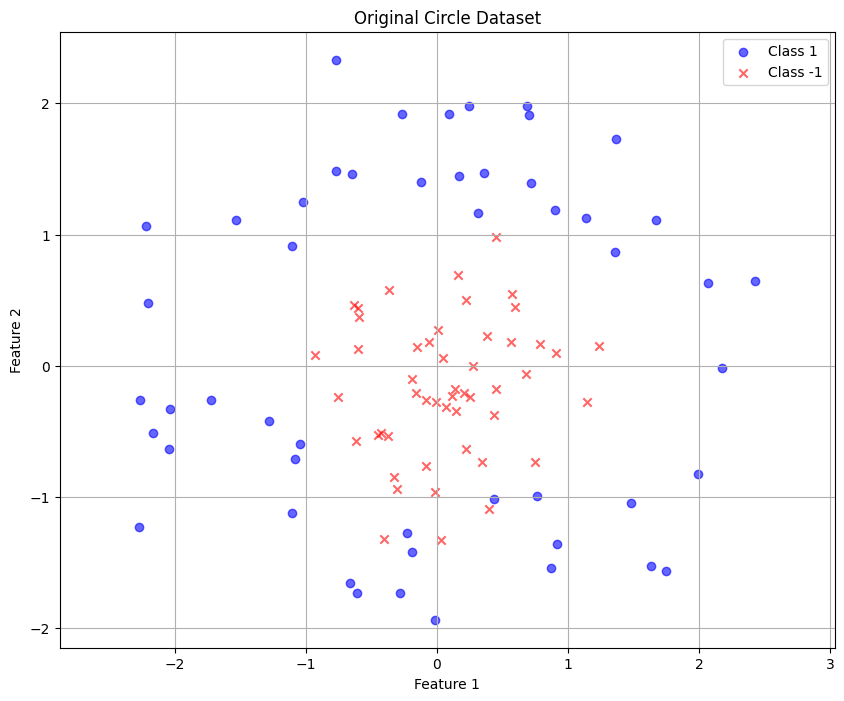

In [9]:
print("Generating circle dataset...")
X_scaled, y = generate_circle_data(n_samples=100, noise=0.1)

print("""
This function creates a scatter plot of the original circle dataset.
Points belonging to different classes are colored differently (blue for Class +1 and red for Class -1).
""")
visualize_data(X_scaled, y, title="Original Circle Dataset")

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print("\nTraining QSVM...")
y_pred = create_and_train_qsvm(X_train, X_test, y_train)

print("\nResults:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training QSVM...
Computing kernel matrices...

Results:
Accuracy: 0.5666666666666667

Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.92      0.65        13
           1       0.83      0.29      0.43        17

    accuracy                           0.57        30
   macro avg       0.67      0.61      0.54        30
weighted avg       0.69      0.57      0.53        30


Results:
Accuracy: 0.5666666666666667

Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.92      0.65        13
           1       0.83      0.29      0.43        17

    accuracy                           0.57        30
   macro avg       0.67      0.61      0.54        30
weighted avg       0.69      0.57      0.53        30




This function visualizes both the true labels and predicted labels of the test dataset after training the QSVM. 
The true classes are shown in blue and red as before while 
      predicted classes are shown in cyan and magenta with a slight transparency to distinguish them from true labels.



/tmp/ipykernel_781035/2800770217.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[y_pred == -1][:, 0], X_test[y_pred == -1][:, 1], c='magenta', marker='x', edgecolor='black', label='Predicted Class -1', alpha=0.4)


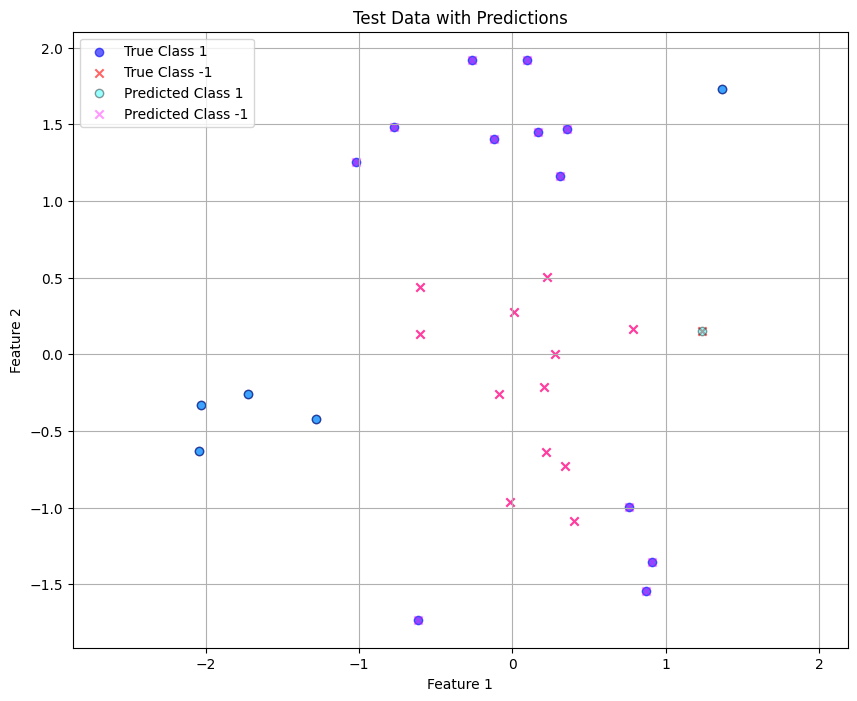

In [11]:
print("""
This function visualizes both the true labels and predicted labels of the test dataset after training the QSVM. 
The true classes are shown in blue and red as before while 
      predicted classes are shown in cyan and magenta with a slight transparency to distinguish them from true labels.
""")
visualize_predictions(X_test, y_test, y_pred)